In [1]:
import tensorflow as tf
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import warnings
warnings.filterwarnings("ignore")

2025-06-15 10:23:29.474168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749983009.568448     907 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749983009.601921     907 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749983009.816359     907 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749983009.816393     907 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749983009.816395     907 computation_placer.cc:177] computation placer alr

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
" /kaggle/input/face-mask-dataset"
print("Path to dataset files:", path)

/home/gaurav/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/gaurav/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

def prepare_dataset(source_dir, target_dir, test_size=0.1, val_size=0.1, seed=42):
    classes = ['with_mask', 'without_mask']
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)

        train_val, test = train_test_split(images, test_size=test_size, random_state=seed)
        train, val = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=seed)

        for split_name, split_data in [('train', train), ('val', val), ('test', test)]:
            split_dir = os.path.join(target_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy(src, dst)

prepare_dataset("data", "face-mask-data", test_size=0.1, val_size=0.1)


In [67]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory("face-mask-data/train", image_size=(35, 35), seed=42)
test_dataset = image_dataset_from_directory("face-mask-data/test", image_size=(35, 35), seed=42)
val_dataset = image_dataset_from_directory("face-mask-data/val", image_size=(35, 35), seed=42)

Found 6026 files belonging to 2 classes.
Found 757 files belonging to 2 classes.
Found 770 files belonging to 2 classes.


In [ ]:
# class_names = test_dataset.class_names
# class_counts = {class_name: 0 for class_name in class_names}

# for images, labels in train_dataset:
#     for label in labels.numpy():
#         class_counts[class_names[label]] += 1

# print(class_counts)

### Data Augmentation

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode="horizontal"),
  layers.RandomRotation(0.07),
])

In [69]:
img, label = next(iter(train_dataset))

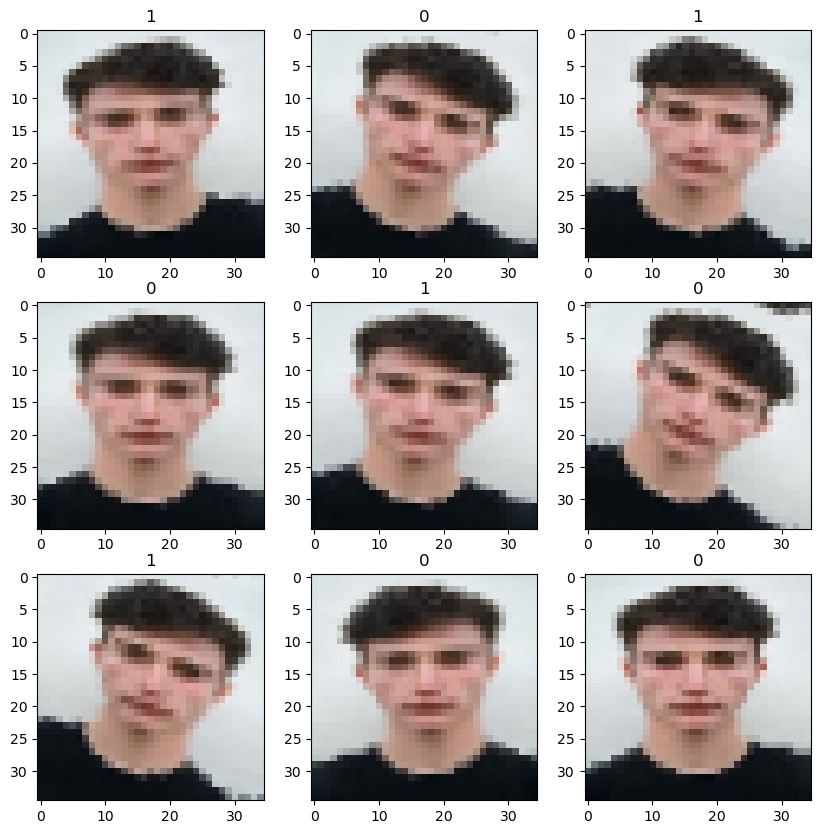

In [70]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
  for j in range(3):
    curr = data_augmentation(tf.cast(tf.expand_dims(img[0], 0), tf.float32))
    curr /= 255.0
    # curr = data_augmentation(img[i + j])
    ax[i][j].imshow(curr[0])
    ax[i][j].set_title(int(label[i + j]))

plt.show()

In [82]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dense, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

model = Sequential([
    Input(shape=(35, 35, 3), batch_size=32),
    Rescaling(1./255),
    data_augmentation, 

    Conv2D(64, kernel_size=(3, 3), padding="same"),
    Conv2D(64, kernel_size=(3, 3), padding="same", dilation_rate=(2, 2)),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), padding="same"),
    Conv2D(128, kernel_size=(3, 3), padding="same", dilation_rate=(2, 2)),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(256, kernel_size=(3, 3), padding="same"),
    Conv2D(256, kernel_size=(3, 3), padding="same", dilation_rate=(2, 2)),
    MaxPooling2D(),
    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, "sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "auc", "precision", "recall"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=10,          # stop if no improvement in 10 epochs
    restore_best_weights=True  # roll back to best model
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=40, callbacks=[early_stop])

Epoch 1/40


In [22]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

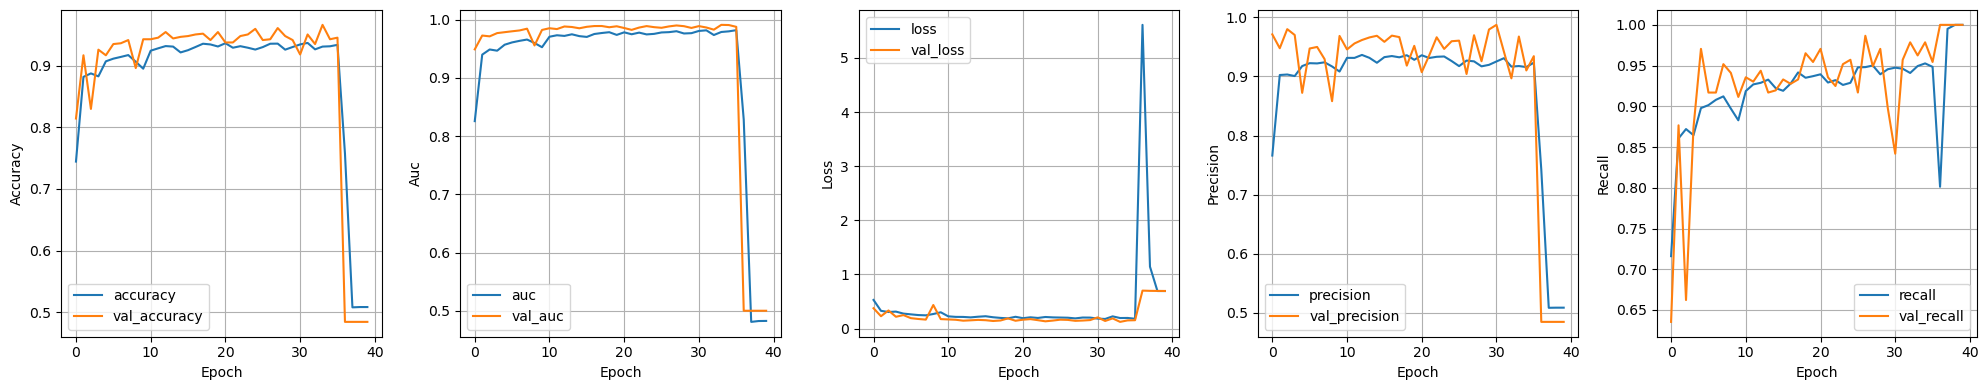

In [80]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 5, figsize=(20, 4))  # Adjust width as needed

for i, item in enumerate(("accuracy", "auc", "loss", "precision", "recall")):
    axis[i].plot(history.history[item], label=item)
    axis[i].plot(history.history["val_" + item], label="val_" + item)
    axis[i].set_xlabel("Epoch")
    axis[i].set_ylabel(item.capitalize())
    axis[i].legend()
    axis[i].grid()

plt.tight_layout()
plt.show()

In [66]:
model.evaluate(val_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9507 - auc: 0.9878 - loss: 0.1319 - precision: 0.9365 - recall: 0.9613


[0.1258746236562729,
 0.948051929473877,
 0.989043116569519,
 0.9463806748390198,
 0.9463806748390198]

In [63]:
model.evaluate(test_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9596 - auc: 0.9919 - loss: 0.1172 - precision: 0.9442 - recall: 0.9789


[0.14220912754535675,
 0.9484808444976807,
 0.9875652194023132,
 0.9334975481033325,
 0.9693094491958618]